In [1]:
'''
ONLY FOR RUNNING THE NOTEBOOK
Sets the root of the notebook to the root of the lib so that imports and functions work
'''

import os
from pathlib import Path

cwd = Path.cwd()

files_found = False
root_path = cwd

while not(files_found):

    gitignore = root_path / '.gitignore'
    readme = root_path / 'README.md'

    files_found = bool(gitignore.exists() * readme.exists())
    if files_found:
        break

    if str(root_path) == root_path.drive + root_path.root:
        raise ValueError('did not find proper dir location. please restart/redefine cwd')

    root_path = root_path.parent

os.chdir(root_path)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import src.functions.mult_lin_reg_utils.model_reduction as mod_red
from src.functions.math_utils.rescale import rescale

# things which are needed

## parameters

In [3]:
# dict where the keys are the encoded feature names and the vals are the actual feature names
features = {'A': 'roll_temperature',
            'B': 'density',
            'C': 'porosity'}

# list of encoded terms for the full MLR model, following patsy rules
linear_terms = list(features.keys())
twoFI_terms = [f'{term1}:{term2}' for term1, term2 in itertools.combinations(linear_terms, 2)]
quadratic_terms = [f'I({term} ** 2)' for term in features.keys()]
terms_list = linear_terms + twoFI_terms + quadratic_terms
print(terms_list)

# response column name in the data
response = '_10C'

['A', 'B', 'C', 'A:B', 'A:C', 'B:C', 'I(A ** 2)', 'I(B ** 2)', 'I(C ** 2)']


## data

### load the data

Pandas dfs containing the data (features and responses) in real units

In [4]:
data = pd.read_excel(root_path / 'docs' / 'examples and guides' / 'auto_mlr_notebook' / 'Data.xlsx', sheet_name='Train Data')
data_test = pd.read_excel(root_path / 'docs' / 'examples and guides' / 'auto_mlr_notebook' / 'Data.xlsx', sheet_name='Test Data')

data

,Run,roll_temperature,density,porosity,C_5_6,_10C
0,1,85,2.7,39.44,161.266470,72.041289
1,2,85,2.7,33.83,163.246313,85.186684
2,3,85,2.7,28.22,163.611265,89.828855
3,4,120,2.7,39.44,162.546693,59.174622
4,6,120,2.7,28.22,162.572572,84.951191
5,7,145,2.7,39.44,160.603309,30.733031
6,8,145,2.7,33.83,161.722686,84.945758
7,9,145,2.7,28.22,162.295969,69.421891
8,10,85,3.2,39.44,160.393884,0.000890
9,12,85,3.2,28.22,162.167545,11.601307


### add encoded columns

column names are the encoded names and values are the [-1, +1] mapping. Using the `rescale` class is very useful for this.

In [5]:
rescalers = {'A': rescale(actual_min=85, actual_max=145, goal_min=-1, goal_max=1), # encoding for RolltemperatureC
             'B': rescale(actual_min=2.7, actual_max=3.2, goal_min=-1, goal_max=1), # encoding for Targetdensitygcm3
             'C': rescale(actual_min=28, actual_max=40, goal_min=-1, goal_max=1) # encoding for Calculatedtargetporosity
             }

# Example usage of rescalers. In the example below, we convert 100°C to the [-1, +1] scale, resulting in -0.5. We can also do the reverse.
print(f"Convertion of 100°C of RolltemperatureC to the encoded value from [-1, +1]: {rescalers['A'].transform(100)}")
print(f"Convertion of -0.5 of RolltemperatureC from encoded value to real: {rescalers['A'].reverse_transform(-0.5)}")

Convertion of 100°C of RolltemperatureC to the encoded value from [-1, +1]: -0.5
Convertion of -0.5 of RolltemperatureC from encoded value to real: 100.0


In [6]:
# use encoders to add the encoded features
for feature_encoded, feature_real in features.items():
    rescaler = rescalers[feature_encoded]
    data[feature_encoded] = data[feature_real].apply(rescaler.transform)
    data_test[feature_encoded] = data_test[feature_real].apply(rescaler.transform)

data # note that A, B, and C columns have been added

,Run,roll_temperature,density,porosity,C_5_6,_10C,A,B,C
0,1,85,2.7,39.44,161.266470,72.041289,-1.000000,-1.0,0.906667
1,2,85,2.7,33.83,163.246313,85.186684,-1.000000,-1.0,-0.028333
2,3,85,2.7,28.22,163.611265,89.828855,-1.000000,-1.0,-0.963333
3,4,120,2.7,39.44,162.546693,59.174622,0.166667,-1.0,0.906667
4,6,120,2.7,28.22,162.572572,84.951191,0.166667,-1.0,-0.963333
5,7,145,2.7,39.44,160.603309,30.733031,1.000000,-1.0,0.906667
6,8,145,2.7,33.83,161.722686,84.945758,1.000000,-1.0,-0.028333
7,9,145,2.7,28.22,162.295969,69.421891,1.000000,-1.0,-0.963333
8,10,85,3.2,39.44,160.393884,0.000890,-1.000000,1.0,0.906667
9,12,85,3.2,28.22,162.167545,11.601307,-1.000000,1.0,-0.963333


# auto_model_reduction example

Below is a minimum example of using `auto_model_reduction`. The output is a dict with several keys

In [7]:
columns = list(features.keys())+[response]
select_data = data[columns].dropna()

reduced_model = mod_red.auto_model_reduction(select_data, # df containing only the encoded columns and a single response
                                                terms_list, # list of terms for the full model
                                                response = response, # the column name of the response
                                                )

reduced_model.keys()

dict_keys(['models', 'model_stats', 'best_models', 'boxcox_info'])

## reduced_model['boxcox_info']

The first key contains Box-Cox transformation info. Several keys are present:
- 'lambdas in conf int': [0.5] -> list of all lambda values which are within the confidence interval. These (plus lambda = 1) will be considered for the best models
- 'lambdas': [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0] -> all lambdas considered (x-axis for the Box-Cox plot)
- 'ln resid sum squares': [np.float64(40.2129995473657), ... -> y-axis values for plotting the Box-Cox plot
- 'confidence interval': np.float64(5.751364583768151) -> critical y-axis value used to determine the confidence interval

In [8]:
reduced_model['boxcox_info']

{'lambdas in conf int': [0.5],
 'lambdas': [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2],
 'ln resid sum squares': [np.float64(40.2129995473657),
  np.float64(31.4458595763419),
  np.float64(22.9138938093626),
  np.float64(14.93020593176773),
  np.float64(8.540595131564578),
  np.float64(5.324586805990373),
  np.float64(6.153607312400972),
  np.float64(8.06686446641273),
  np.float64(9.977111140456692)],
 'confidence interval': np.float64(5.751364583768151)}

example Box-Cox plot. The lambdas considered for best_models are 1 as well as the lambdas below the critical value. In the example below, onle [0.5, 1] are considered.

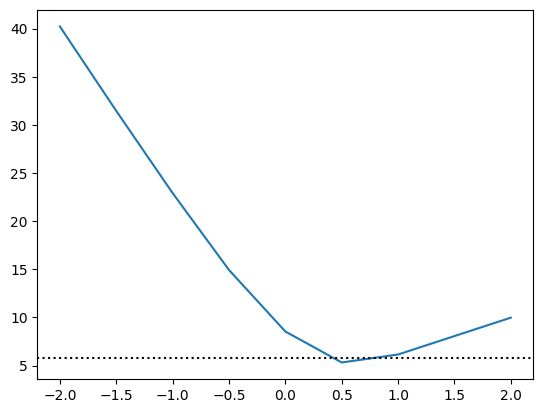

In [9]:
plt.plot(reduced_model['boxcox_info']['lambdas'], reduced_model['boxcox_info']['ln resid sum squares'])
plt.axhline(reduced_model['boxcox_info']['confidence interval'], c='k', ls=':')

# reduced_model['models']

Nested dictionary, where the first key is the lambda value, the next key is the critical statistic ('aicc' or 'bic'), and the last key is the direction ('forwards' or 'backwards'). For example, `reduced_model['models'][1]['aicc']['forwards]`. The value is the fitted `statsmodels OLS` object (often called `results`)

In [10]:
reduced_model['models']

{1: {'aicc': {'forwards': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x211f8c8dd30>,
   'backwards': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x211f8c9f370>},
  'bic': {'forwards': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x211c3c55400>,
   'backwards': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x211c3c3ab50>}},
 0.5: {'aicc': {'forwards': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x211c3ba5d90>,
   'backwards': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x211c3b8c250>},
  'bic': {'forwards': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x211f8cc21f0>,
   'backwards': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x211f8d034f0>}}}

# reduced_model['model_stats'] and reduced_model['best_models']

model_stats is a dictionary where the key is the lambda value and value is a Pandas df containing all the important statistics related to the fitting, including R2 and model coefficients. best_models is similar in that it is a dictionary where the key is the lambda and the value is the same df from model_stats but only contains the stats from the "best" model. See the docstring from `mod_red.get_better_model` to understand the logic for determining the best model.

In [11]:
reduced_model['model_stats'][1]

,response,lambda,r2adj,r2press,d_r2s,key_stat,direction,num_terms,formulas,Intercept,A,B,C,A:B,I(C ** 2),B:C,I(B ** 2)
0,_10C,1,0.948297,0.911668,0.036629,aicc,forwards,6,_10C~A+B+C+A:B+I(C**2),51.095831,-5.452495,-31.463465,-11.310047,4.598592,-15.770334,NaN,NaN
1,_10C,1,0.948297,0.911668,0.036629,aicc,backwards,6,_10C~A+B+C+A:B+I(C**2),51.095831,-5.452495,-31.463465,-11.310047,4.598592,-15.770334,NaN,NaN
2,_10C,1,0.957642,0.919315,0.038327,bic,forwards,7,_10C~A+B+C+A:B+B:C+I(C**2),51.095831,-5.452495,-31.343177,-11.310047,4.598592,-15.770334,4.245458,NaN
3,_10C,1,0.957642,0.919315,0.038327,bic,backwards,8,_10C~A+B+C+A:B+B:C+I(B**2)+I(C**2),25.547915,-5.452495,-31.343177,-11.310047,4.598592,-15.770334,4.245458,25.547915


When looking at best_models, each best/recommended model per lambda needs to be manually reviewed. Choose the lambda that makes the most sense and use that as your final model.

In [ ]:
reduced_model['best_models'][1] # same table as above, after picking the best option when varying [aicc vs bic] and [forwards vs backwards]

,response,lambda,r2adj,r2press,d_r2s,key_stat,direction,num_terms,formulas,Intercept,A,B,C,A:B,I(C ** 2),B:C,I(B ** 2)
0,_10C,1,0.948297,0.911668,0.036629,aicc,forwards,6,_10C~A+B+C+A:B+I(C**2),51.095831,-5.452495,-31.463465,-11.310047,4.598592,-15.770334,NaN,NaN


In [20]:
reduced_model['best_models'][0.5]

,response,lambda,r2adj,r2press,d_r2s,key_stat,direction,num_terms,formulas,Intercept,B,C,I(C ** 2),A,A:B,B:C,I(A ** 2),I(B ** 2)
0,_10C,0.5,0.930994,0.906059,0.024935,aicc,forwards,4,_10C~B+C+I(C**2),6.674823,-2.825238,-1.355651,-1.8289,NaN,NaN,NaN,NaN,NaN


# auto_model_reduction example2: with group R2press

`auto_model_reduction` can also calculate R2press with grouping. For example, say you are working with a DoE where you change temperature (A), pressure (B), and take measurements (y) at specified timesteps (C), say every 5mins. So the final model is `y ~ A + B + C`. If you calculate PRESS as leave-one-out, the R2press will artificially be high. For example, your training set will have 25°C, 1bar, at 15mins and 25mins then try to predict 20mins. Technically, all these points are from a single run and there is information leak from this run during the R2press calculation. The correct way would be to remove all the 25°C, 1bar, all time step data then calculate R2press.

This is implemented using the groupby_cols kwarg. See the drop in r2press from 0.9117 to 0.9114. This example is a very small example since this data set is small, but if you have DoE data and you take measurements to the point where you increase your data set 10x, this becomes more important.

In [22]:
reduced_model = mod_red.auto_model_reduction(select_data,
                                                terms_list,
                                                response = response,
                                                groupby_cols = ['A', 'B'] # added
                                                )

reduced_model['best_models'][1]

,response,lambda,r2adj,r2press,d_r2s,key_stat,direction,num_terms,formulas,Intercept,A,B,C,A:B,I(C ** 2),B:C,I(B ** 2)
0,_10C,1,0.948297,0.911417,0.036879,aicc,forwards,6,_10C~A+B+C+A:B+I(C**2),51.095831,-5.452495,-31.463465,-11.310047,4.598592,-15.770334,NaN,NaN
